# **Exercício Prático 05 - Máquinas de Vetor Suporte**
## Aprendizado de Máquina A
### **Professor(es):** Gisele Lobo Pappa e Lourenço Ribeiro Grossi Araújo
### **Aluno:** Bernardo Reis de Almeida

### **Imports**

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.patches as patches

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

### **SVM Linear no Dataset Simples (2D)**

#### Implementação e Treinamento

In [2]:
# Implementing the model
class SVM:
    def __init__(self, C: float = 1.0, alpha: float = 0.001, max_iter: int = 1000):
        self.coef = None
        self.bias = None
        self.C = C
        self.alpha = alpha
        self.max_iter = max_iter

    def fit(self, X, y):
        self.coef = np.zeros((X.shape[1],))
        self.bias = 0.0

        iter = 0
        while True:
            for i in range(len(X)):
                grad_coef = 0
                grad_bias = 0
                sample_prediction = y[i] * ((self.coef @ X[i].T) + self.bias)

                if sample_prediction >= 1:
                    grad_coef = self.coef
                    grad_bias = 0

                elif sample_prediction < 1:
                    grad_coef = self.coef - self.C * y[i] * X[i]
                    grad_bias = -self.C * y[i]

                self.coef -= self.alpha * grad_coef
                self.bias -= self.alpha * grad_bias

            iter += 1

            # Stops if everyone is correctly categorized
            # or if max_iter is reached
            if (sum(y - self.predict(X)) == 0) or (iter >= self.max_iter):
                break

    def predict(self, X):
        predictions = np.zeros((X.shape[0],))
        for i in range(len(X)):
            sample_prediction = (self.coef @ X[i].T) + self.bias
            predictions[i] = 1 if sample_prediction > 0 else -1
        return predictions

    def get_support_vectors(self, X):
        support_vectors = []
        for i in range(len(X)):
            if (abs(self.coef @ X[i].T + self.bias) >= 0.99) and (
                abs(self.coef @ X[i].T + self.bias) <= 1.01
            ):
                support_vectors.append(X[i])
        return np.array(support_vectors)

In [3]:
# Reading the data
df = pd.read_csv("dados/dados_svm_simples.csv")

# Stratified train/test separation
minus_one = df[df["y"] == -1].copy()
plus_one = df[df["y"] == 1].copy()

minus_one_split = int(0.7 * minus_one.shape[0])
plus_one_split = int(0.7 * plus_one.shape[0])

train = pd.concat(
    [minus_one.iloc[:minus_one_split], plus_one.iloc[:plus_one_split]]
).reset_index(drop=True)
X_train = train[["x1", "x2"]].to_numpy()
y_train = train["y"].to_numpy()

test = pd.concat(
    [minus_one.iloc[minus_one_split:], plus_one.iloc[plus_one_split:]]
).reset_index(drop=True)
X_test = test[["x1", "x2"]].to_numpy()
y_test = test["y"].to_numpy()

In [4]:
# Training the model on the train data
svm = SVM(C=10, max_iter=1000)
svm.fit(X_train, y_train)

#### (a) Visualizações

In [5]:
# Calculating the actual size of the margin
ro = 2 / np.linalg.norm(svm.coef)

In [6]:
# Getting the support vectors
support_vectors = svm.get_support_vectors(X_train)

print(f"N° of support vectors: {len(support_vectors)}")

N° of support vectors: 6


In [7]:
# Creating two points to plot the hyperplane
hyperplane_y = [3, -3]
hyperplane_x = [
    ((-svm.bias - svm.coef[1] * hyperplane_y[0]) / svm.coef[0]),
    ((-svm.bias - svm.coef[1] * hyperplane_y[1]) / svm.coef[0]),
]

# Creating two points to plot the left margin
left_y = [3, -3]
left_x = [
    ((1 - svm.bias - svm.coef[1] * left_y[0]) / svm.coef[0]),
    ((1 - svm.bias - svm.coef[1] * left_y[1]) / svm.coef[0]),
]

# Creating two points to plot the right margin
right_y = [3, -3]
right_x = [
    ((-1 - svm.bias - svm.coef[1] * right_y[0]) / svm.coef[0]),
    ((-1 - svm.bias - svm.coef[1] * right_y[1]) / svm.coef[0]),
]

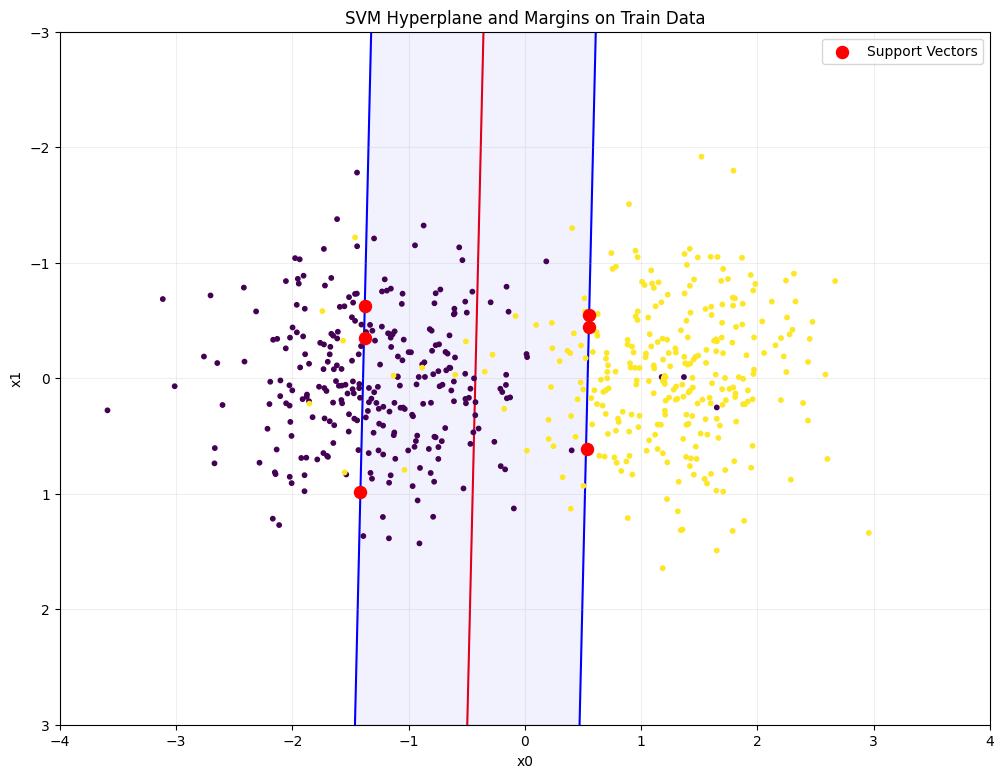

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, zorder=1, s=10)
ax.scatter(
    x=support_vectors[:, 0],
    y=support_vectors[:, 1],
    color="red",
    zorder=2,
    label="Support Vectors",
    s=75,
)
ax.plot(hyperplane_x, hyperplane_y, color="red", zorder=0)
ax.plot(left_x, left_y, color="blue", zorder=0)
ax.plot(right_x, right_y, color="blue", zorder=0)

ax.fill(
    hyperplane_x + left_x[::-1],
    hyperplane_y + left_y[::-1],
    color="blue",
    alpha=0.05,
    zorder=0,
)
ax.fill(
    hyperplane_x + right_x[::-1],
    hyperplane_y + right_y[::-1],
    color="blue",
    alpha=0.05,
    zorder=0,
)
ax.set_xlim((-4, 4))
ax.set_ylim(hyperplane_y)

ax.set_axisbelow(True)
plt.grid(alpha=0.2)

ax.set_title("SVM Hyperplane and Margins on Train Data")
ax.set_xlabel("x0")
ax.set_ylabel("x1")
ax.legend()

plt.show()
plt.close()

#### (b) Fronteira de Decisão

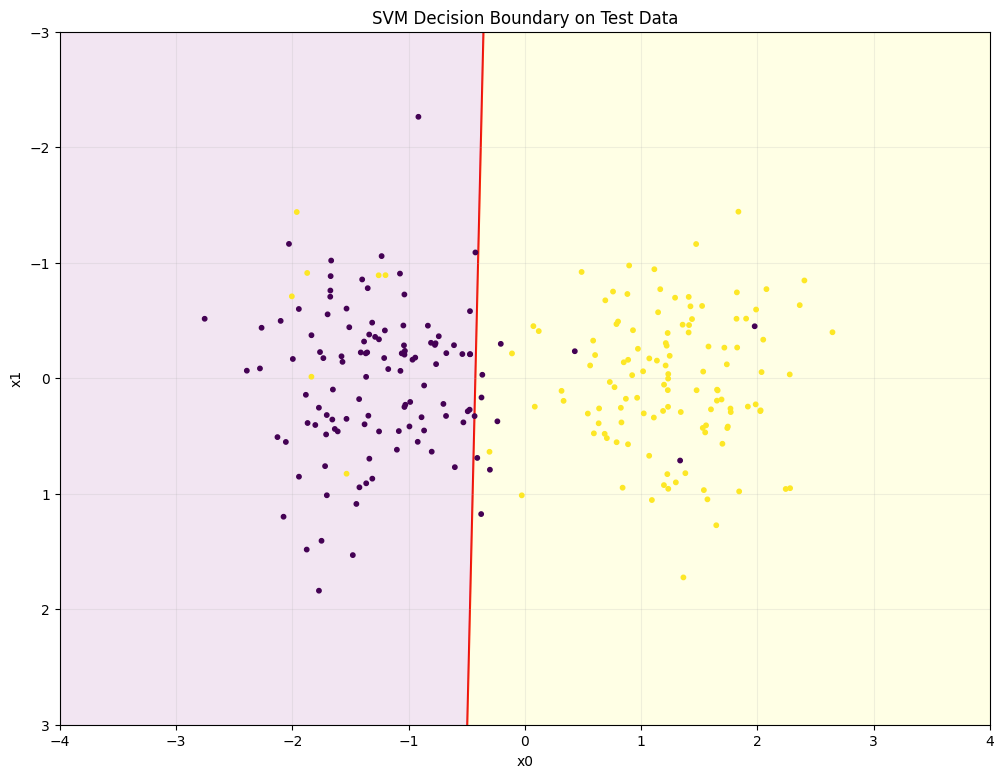

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 9)

ax.scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test, zorder=1, s=10)
ax.plot(hyperplane_x, hyperplane_y, color="red", zorder=0)

ax.fill(
    hyperplane_x + [1000, 1000],
    hyperplane_y + [-1000, 1000],
    color="yellow",
    alpha=0.1,
    zorder=0,
)
ax.fill(
    hyperplane_x + [-1000, -1000],
    hyperplane_y + [-1000, 1000],
    color="purple",
    alpha=0.1,
    zorder=0,
)
ax.set_xlim((-4, 4))
ax.set_ylim(hyperplane_y)

ax.set_axisbelow(True)
plt.grid(alpha=0.2)

ax.set_title("SVM Decision Boundary on Test Data")
ax.set_xlabel("x0")
ax.set_ylabel("x1")

plt.show()
plt.close()

#### (c) Divisão Treino/Teste e Resultados

In [10]:
# Compute accuracy in train
train_predictions = svm.predict(X_train)
train_accuracy = sum(train_predictions == y_train) / len(y_train)

print(f"Train Accuracy: {train_accuracy}")

# Computes the confusion matrix for train set
train_predictions = pd.Series(train_predictions)

true_minus = y_train == -1
true_plus = y_train == 1

true_negative = sum(train_predictions[true_minus] == -1)
false_negative = sum(train_predictions[true_plus] == -1)

true_positive = sum(train_predictions[true_plus] == 1)
false_positive = sum(train_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Train Accuracy: 0.9410714285714286


,True Negative,True Positive,Total
Predicted Negative,250,10,260
Predicted Positive,23,277,300
Total,273,287,560


In [11]:
# Compute accuracy in test
test_predictions = svm.predict(X_test)
test_accuracy = sum(test_predictions == y_test) / len(y_test)

print(f"Test Accuracy: {test_accuracy}")

# Computes the confusion matrix for test set
test_predictions = pd.Series(test_predictions)

true_minus = y_test == -1
true_plus = y_test == 1

true_negative = sum(test_predictions[true_minus] == -1)
false_negative = sum(test_predictions[true_plus] == -1)

true_positive = sum(test_predictions[true_plus] == 1)
false_positive = sum(test_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Test Accuracy: 0.925


,True Negative,True Positive,Total
Predicted Negative,106,7,113
Predicted Positive,11,116,127
Total,117,123,240


#### (d) Discussão

Entre um conjunto de dados linearmente separável, existem infinitos hiperplanos capazes de distinguir perfeitamente as classes. Cada hiperplano pode ser caracterizado por uma expressão na forma $w^tx+b=0$, em que $w$ é um vetor de coeficientes e $b$, um termo de viés. A ideia do SVM é encontrar um desses hiperplanos que seja razoavelmente robusto a novos dados de entrada, principalmente àqueles próximos à fronteira de decisão. Para isso, este algoritmo encontra o hiperplano que maximiza a margem de separação $ρ$, a qual pode ser entendida como a distância entre a fronteira de decisão e os pontos de ambas as classes mais próximos dela, os quais passam a ser chamados de vetores de suporte.

Entretanto, há situações nas quais os dados são apenas quase linearmente separáveis, como é o caso dos dados utilizados nesta etapa do trabalho. Em contextos como este, é possível adaptar o algoritmo do SVM para admitir um relaxamento no processo de otimização, o qual permite com que alguns pontos passem do hiperplano de separação, o qual tenta, agora, maximizar a sua margem e, ao mesmo tempo, minimizar a magnitude dessa transgressão. O termo responsável por este último objetivo é ponderado por um hiperparâmetro $C$, de modo que, quanto maior seu valor, mais a magnitude da transgressão impacta a função de perda e mais "justo" fica o ajuste do hiperplano, no sentido de que ele irá permitir que menos pontos passem da fronteira de separação.

A partir da visualização gerada, é possível observar como um hiperplano razoavelmente robusto foi encontrado, no sentido de que ele dá uma margem boa entre cada uma das classes. Além disso, também é possível ver como foi permitida a transgressão de alguns pontos para a margem da classe oposta, destacando o fato de que o conjunto de dados possui uma fronteira de separação aproximadamente linear, porém não perfeitamente separável. De qualquer forma, a acurácia obtida no conjunto de testes foi extremamente razoável, demonstrando a eficácia do método neste problema.

### **SVM Linear no Dataset Complexo (Diagnóstico de Limitação)**

#### (a) Treinamento na Base de Dados Complexa

In [12]:
# Reading the data
df = pd.read_csv("dados/dados_svm_complexo.csv")
X = df[[f"x{i}" for i in range(1, 9)]].to_numpy()
y = df["y"].to_numpy()

# Stratified train/test separation
minus_one = df[df["y"] == -1].copy()
plus_one = df[df["y"] == 1].copy()

minus_one_split = int(0.7 * minus_one.shape[0])
plus_one_split = int(0.7 * plus_one.shape[0])

train = pd.concat(
    [minus_one.iloc[:minus_one_split], plus_one.iloc[:plus_one_split]]
).reset_index(drop=True)
X_train = train[[f"x{i}" for i in range(1, 9)]].to_numpy()
y_train = train["y"].to_numpy()

test = pd.concat(
    [minus_one.iloc[minus_one_split:], plus_one.iloc[plus_one_split:]]
).reset_index(drop=True)
X_test = test[[f"x{i}" for i in range(1, 9)]].to_numpy()
y_test = test["y"].to_numpy()

In [13]:
# Training the model on the train data
svm = SVM(C=1, max_iter=1000)
svm.fit(X_train, y_train)

#### (b) Visualizações

In [14]:
# Computing model predictions
train_predictions = svm.predict(X_train)
test_predictions = svm.predict(X_test)

In [15]:
# PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)  # Generates a dimension for all the data

pca_X = pca.transform(X)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)

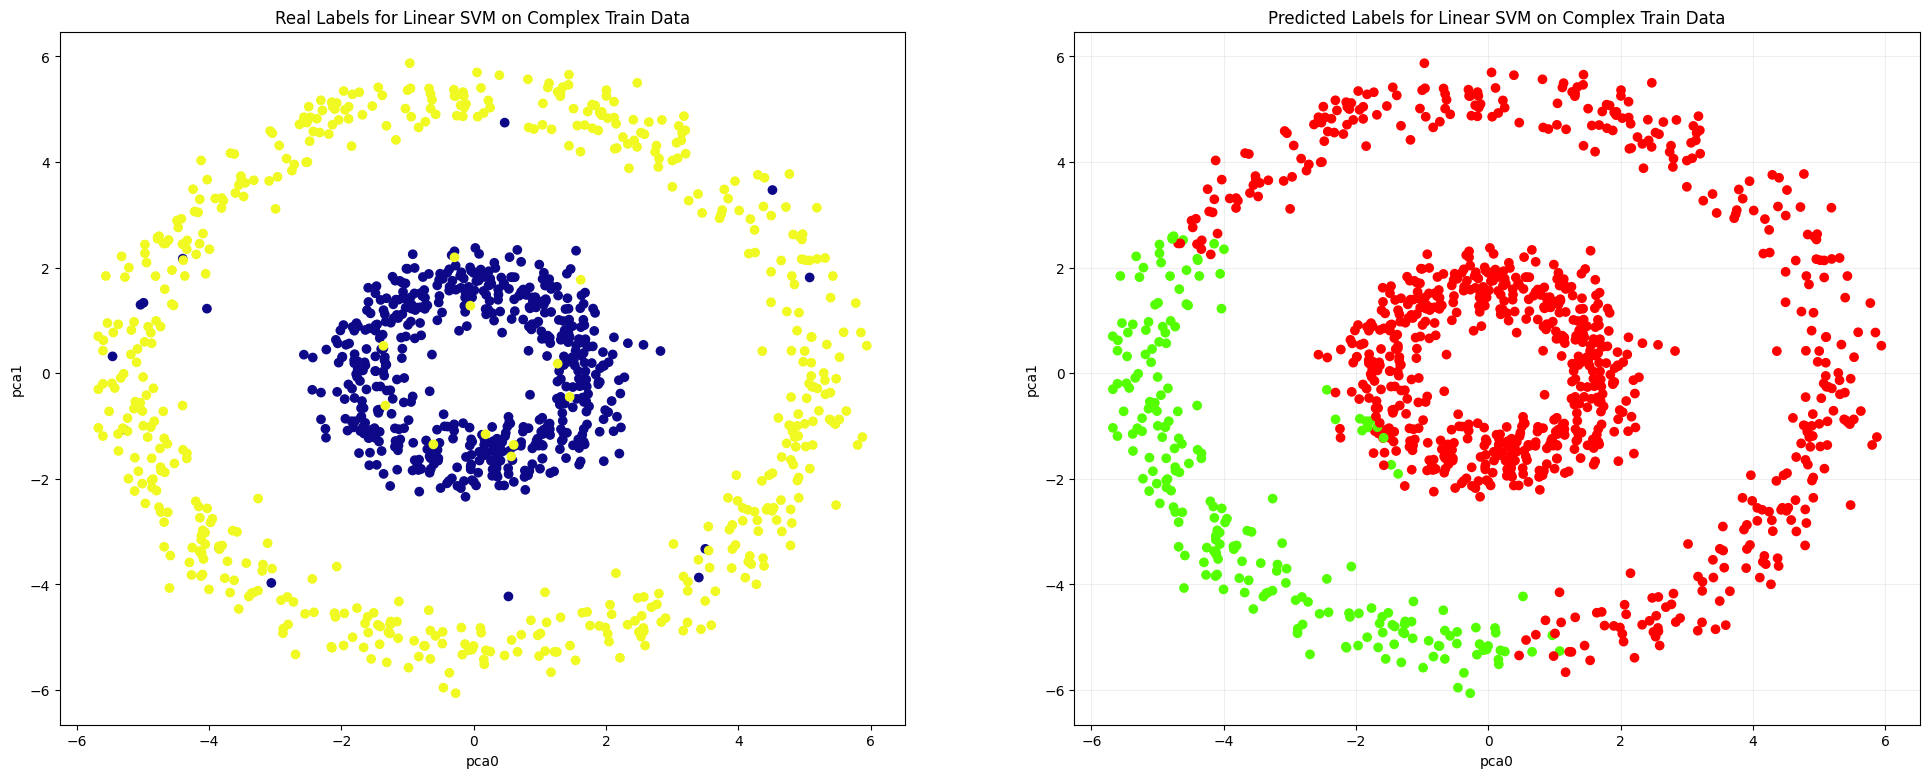

In [16]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(
    x=pca_X_train[:, 0], y=pca_X_train[:, 1], c=y_train, cmap="plasma", zorder=1
)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Linear SVM on Complex Train Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=pca_X_train[:, 0],
    y=pca_X_train[:, 1],
    c=train_predictions,
    cmap="prism",
    zorder=1,
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Linear SVM on Complex Train Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

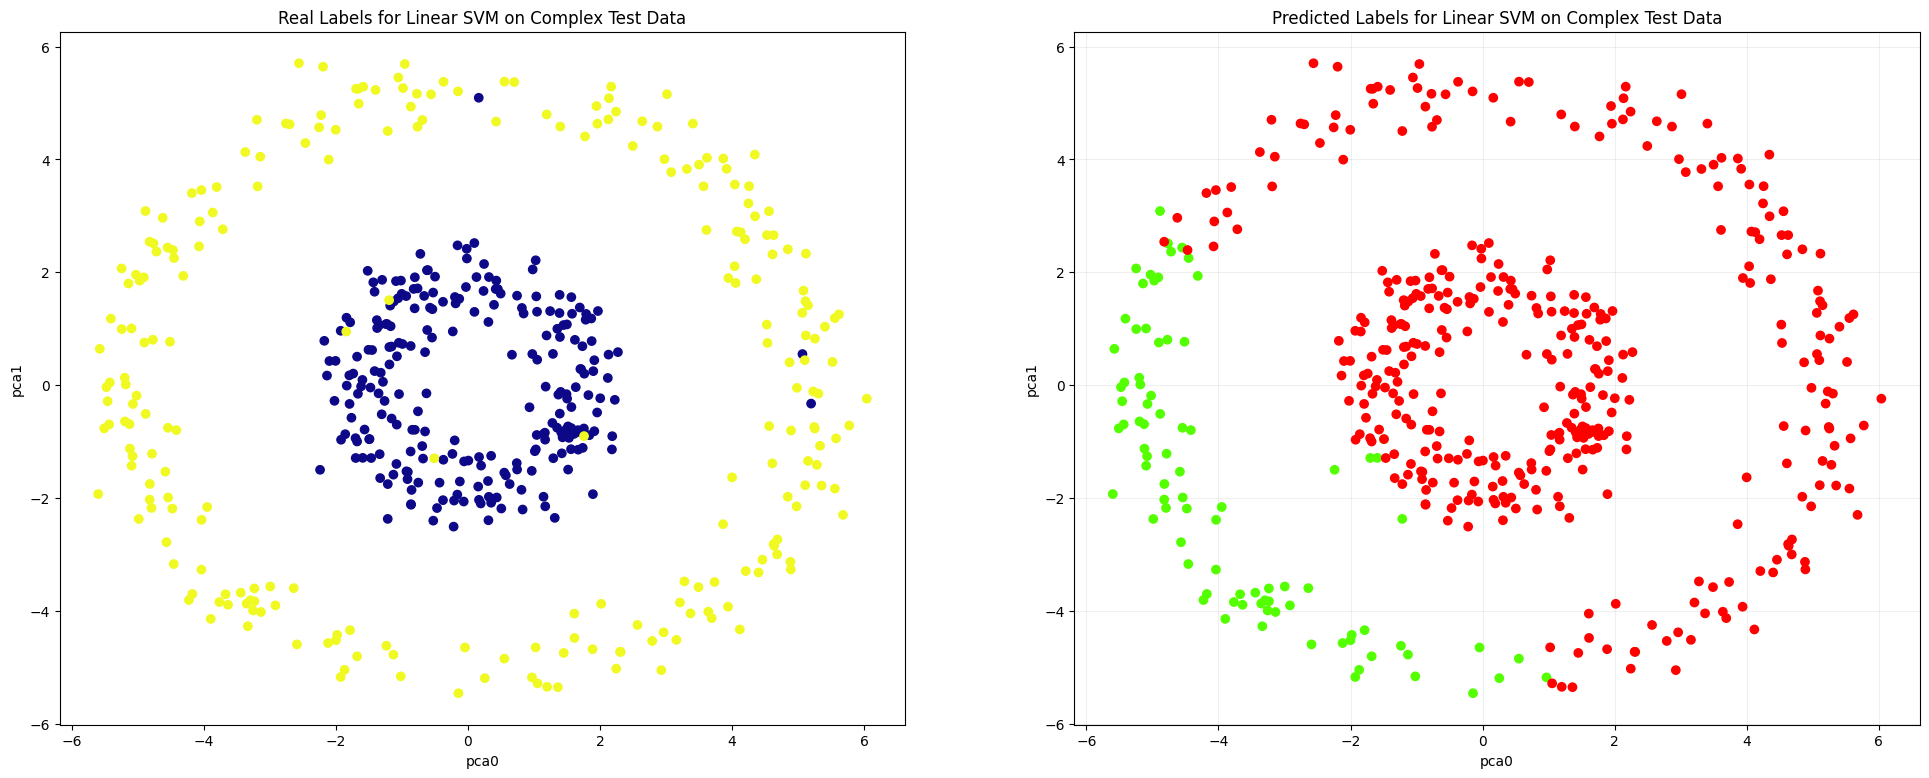

In [17]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(x=pca_X_test[:, 0], y=pca_X_test[:, 1], c=y_test, cmap="plasma", zorder=1)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Linear SVM on Complex Test Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=pca_X_test[:, 0], y=pca_X_test[:, 1], c=test_predictions, cmap="prism", zorder=1
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Linear SVM on Complex Test Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

#### (c) Divisão Treino/Teste e Resultados

In [18]:
# Compute accuracy in train
train_predictions = svm.predict(X_train)
train_accuracy = sum(train_predictions == y_train) / len(y_train)

print(f"Train Accuracy: {train_accuracy}")

# Computes the confusion matrix for train set
train_predictions = pd.Series(train_predictions)

true_minus = y_train == -1
true_plus = y_train == 1

true_negative = sum(train_predictions[true_minus] == -1)
false_negative = sum(train_predictions[true_plus] == -1)

true_positive = sum(train_predictions[true_plus] == 1)
false_positive = sum(train_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Train Accuracy: 0.6621983914209115


,True Negative,True Positive,Total
Predicted Negative,540,357,897
Predicted Positive,21,201,222
Total,561,558,1119


In [19]:
# Compute accuracy in test
test_predictions = svm.predict(X_test)
test_accuracy = sum(test_predictions == y_test) / len(y_test)

print(f"Test Accuracy: {test_accuracy}")

# Computes the confusion matrix for test set
test_predictions = pd.Series(test_predictions)

true_minus = y_test == -1
true_plus = y_test == 1

true_negative = sum(test_predictions[true_minus] == -1)
false_negative = sum(test_predictions[true_plus] == -1)

true_positive = sum(test_predictions[true_plus] == 1)
false_positive = sum(test_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Test Accuracy: 0.6611226611226612


,True Negative,True Positive,Total
Predicted Negative,236,158,394
Predicted Positive,5,82,87
Total,241,240,481


#### (d) Discussão

Como já mencionado, o modelo de SVM implementado até aqui é robusto a dados quase linearmente separáveis por meio de um relaxamento no ajuste da margem. Porém, para dados cuja fronteira de separação entre classes é não-linear, como é o caso do conjunto utilizado nesta etapa - os quais possuem uma fronteira de separação elíptica, como observável nas visualizações produzidas -, o algoritmo do SVM falha, já que ele consegue encontrar apenas hiperplanos e, portanto, separar dados linearmente.

De fato, a partir das visualizações geradas, é possível notar como a fronteira de decisão obtida separa linearmente os dados, mesmo que isso seja efetivamente incompatível com a distribuição espacial de suas classes reais. O resultado disso, como também apresentado, são taxas de acurácia, tanto para os dados de treino, quanto para os dados de teste, não satisfatórias.

Um detalhe interessante a ser notado é que, por mais inadequado que ele seja, o modelo foi capaz de classificar corretamente quase todos os pontos pertencentes à classe negativa, a qual corresponde à elipse de dentro das visualizações. O desempenho do modelo foi muito pior focando-se apenas na classe positiva, para a qual a maior parte das instâncias foi classificada incorretamente. Entretanto, pensa-se que isso seja apenas uma consequência da maneira como os dados foram separados, a qual posicionou o hiperplano de modo que quase todos os pontos da classe negativa recaíssem sobre o mesmo subespaço e, incidentalmente, fossem classificados corretamente. De fato, parece ser mais fácil separar a elipse interna do que a elipse externa e, potencialmente, esse foi o resultado que otimizou a função de perda do algoritmo - o melhor que ele conseguiu fazer -, mesmo que inadequado ao problema em mãos.

### **SVM com Kernel RBF (Não-Linearidade Sem Complicar a Otimização)**

#### Implementação

In [20]:
class NonLinearSVM:
    def __init__(self, support_vectors, dual_coef, intercept, gamma: float = 1 / 8):
        self.support_vectors = support_vectors
        self.dual_coef = dual_coef
        self.intercept = intercept
        self.gamma = gamma

    def predict(self, X):
        predictions = np.zeros((X.shape[0],))
        for i in range(len(X)):
            sample_prediction = 0.0
            for j in range(len(self.support_vectors)):
                K = np.exp(
                    (-self.gamma)
                    * np.pow(np.linalg.norm(self.support_vectors[j] - X[i]), 2)
                )
                sample_prediction += self.dual_coef[j] * K
            sample_prediction += self.intercept
            predictions[i] = 1 if sample_prediction > 0 else -1
        return predictions

#### Dados Simples

##### (a) Normalização

In [21]:
# Reading the data
df = pd.read_csv("dados/dados_svm_simples.csv")
X = df[["x1", "x2"]].to_numpy()
y = df["y"].to_numpy()

# Stratified train/test separation
minus_one = df[df["y"] == -1].copy()
plus_one = df[df["y"] == 1].copy()

minus_one_split = int(0.7 * minus_one.shape[0])
plus_one_split = int(0.7 * plus_one.shape[0])

train = pd.concat(
    [minus_one.iloc[:minus_one_split], plus_one.iloc[:plus_one_split]]
).reset_index(drop=True)
X_train = train[["x1", "x2"]].to_numpy()
y_train = train["y"].to_numpy()

test = pd.concat(
    [minus_one.iloc[minus_one_split:], plus_one.iloc[plus_one_split:]]
).reset_index(drop=True)
X_test = test[["x1", "x2"]].to_numpy()
y_test = test["y"].to_numpy()

# Normalizes data with z-score
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

##### (b) Treino com Biblioteca

In [22]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", gamma=1 / 8)
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,0.125
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### (c) Extração de Parâmetros

In [23]:
support_vectors = model.support_vectors_
dual_coef = model.dual_coef_[0]
intercept = model.intercept_[0]

print(f"N° of support vectors: {len(support_vectors)}")
print(f"N° of dual coefficients: {len(dual_coef)}")
print(f"Intercept Value: {intercept}")

N° of support vectors: 101
N° of dual coefficients: 101
Intercept Value: 0.2644560360220027


##### (d) Reconstrução Manual da Decisão

In [24]:
nl_svm = NonLinearSVM(support_vectors, dual_coef, intercept)

##### (e) Verificação

In [25]:
model_predictions = model.predict(X_train)
manual_predictions = nl_svm.predict(X_train)

agreement = sum(model_predictions == manual_predictions) / len(X_train)
print(f"The agreement rate is {agreement}.")

The agreement rate is 1.0.


##### (f) Fronteiras de Decisão

In [26]:
# Computing model predictions
train_predictions = nl_svm.predict(X_train)
test_predictions = nl_svm.predict(X_test)

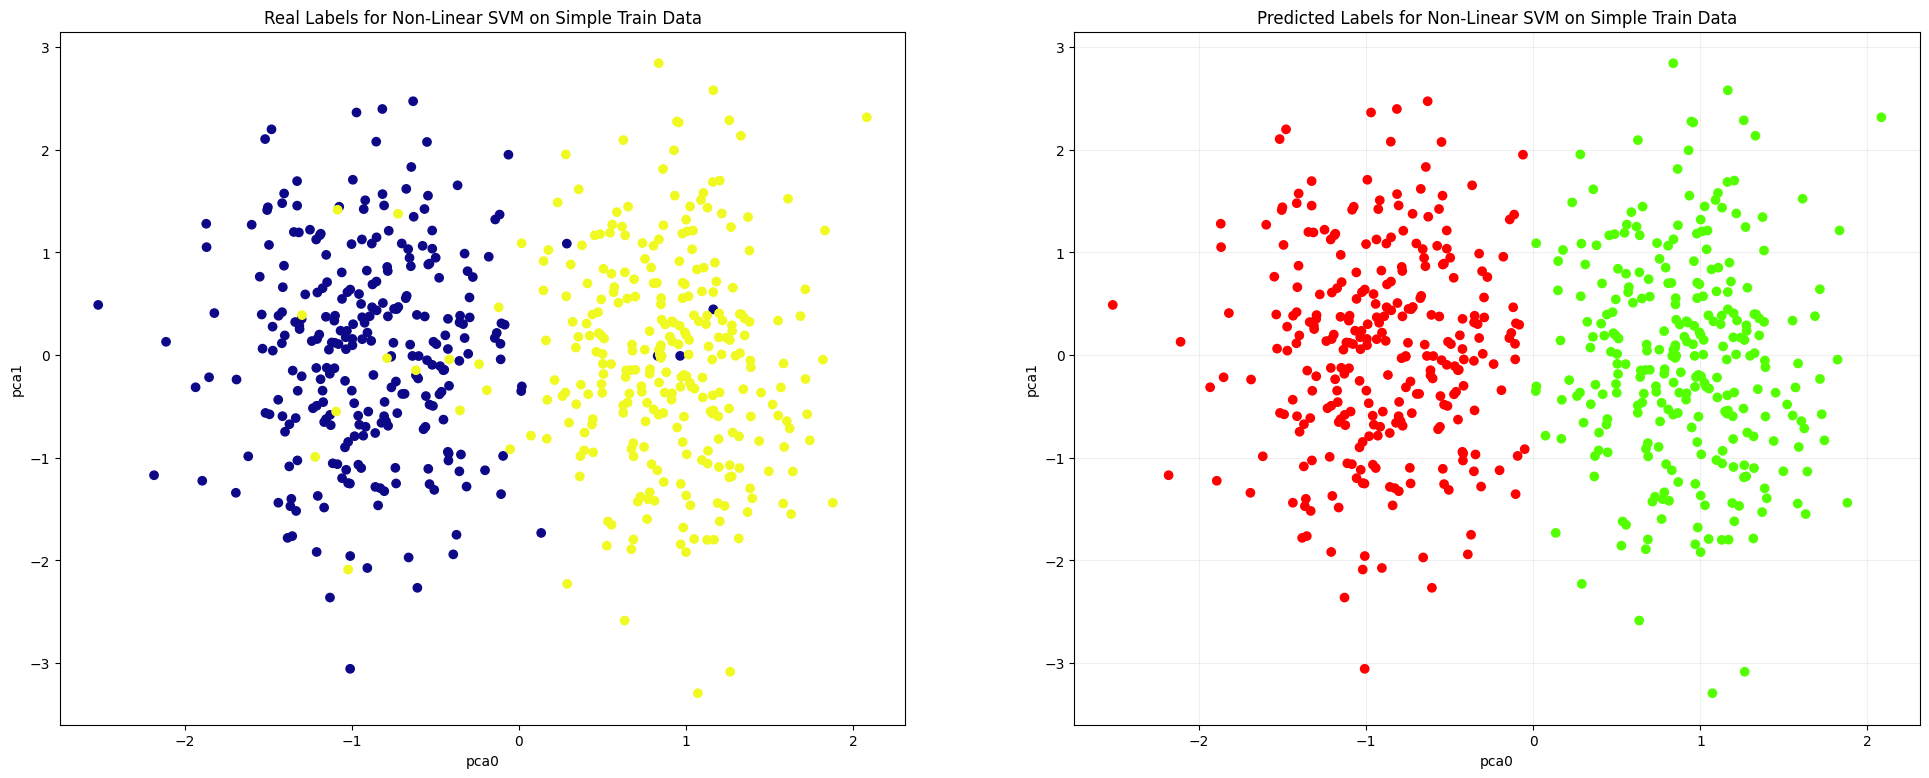

In [27]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(x=X_train[:, 0], y=X_train[:, 1], c=y_train, cmap="plasma", zorder=1)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Non-Linear SVM on Simple Train Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=X_train[:, 0],
    y=X_train[:, 1],
    c=train_predictions,
    cmap="prism",
    zorder=1,
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Non-Linear SVM on Simple Train Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

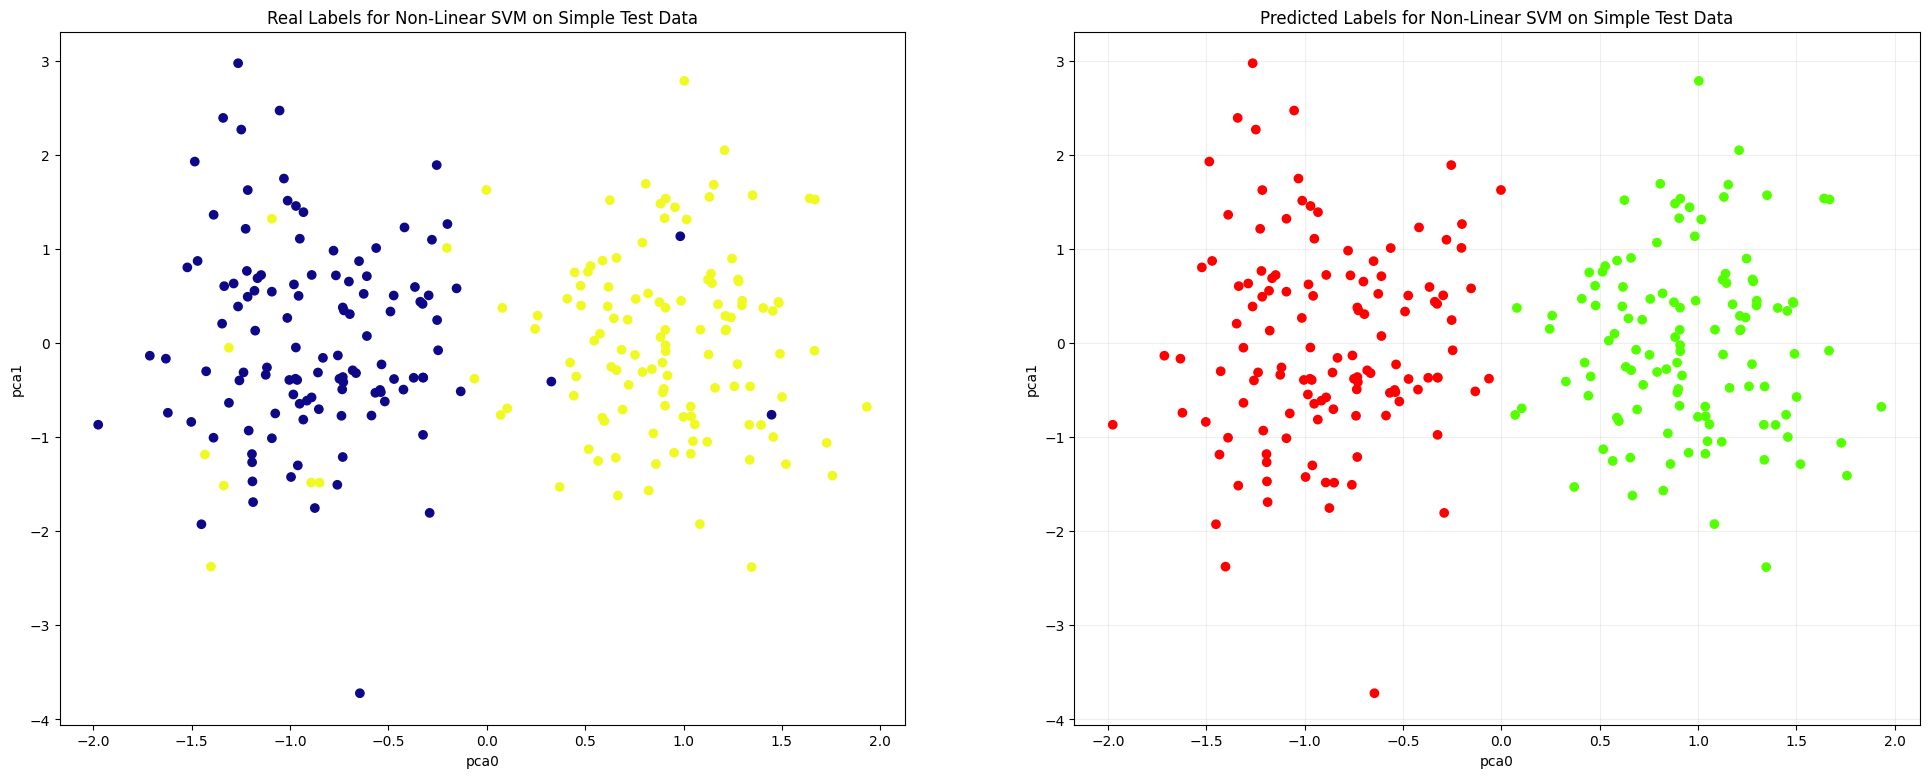

In [28]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(x=X_test[:, 0], y=X_test[:, 1], c=y_test, cmap="plasma", zorder=1)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Non-Linear SVM on Simple Test Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=X_test[:, 0], y=X_test[:, 1], c=test_predictions, cmap="prism", zorder=1
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Non-Linear SVM on Simple Test Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

##### (g) Desempenho

In [29]:
# Compute accuracy in train
train_predictions = nl_svm.predict(X_train)
train_accuracy = sum(train_predictions == y_train) / len(y_train)

print(f"Train Accuracy: {train_accuracy}")

# Computes the confusion matrix for train set
train_predictions = pd.Series(train_predictions)

true_minus = y_train == -1
true_plus = y_train == 1

true_negative = sum(train_predictions[true_minus] == -1)
false_negative = sum(train_predictions[true_plus] == -1)

true_positive = sum(train_predictions[true_plus] == 1)
false_positive = sum(train_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Train Accuracy: 0.9625


,True Negative,True Positive,Total
Predicted Negative,266,14,280
Predicted Positive,7,273,280
Total,273,287,560


In [30]:
# Compute accuracy in test
test_predictions = nl_svm.predict(X_test)
test_accuracy = sum(test_predictions == y_test) / len(y_test)

print(f"Test Accuracy: {test_accuracy}")

# Computes the confusion matrix for test set
test_predictions = pd.Series(test_predictions)

true_minus = y_test == -1
true_plus = y_test == 1

true_negative = sum(test_predictions[true_minus] == -1)
false_negative = sum(test_predictions[true_plus] == -1)

true_positive = sum(test_predictions[true_plus] == 1)
false_positive = sum(test_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Test Accuracy: 0.9458333333333333


,True Negative,True Positive,Total
Predicted Negative,114,10,124
Predicted Positive,3,113,116
Total,117,123,240


#### Dados Complexos

##### (a) Normalização

In [31]:
# Reading the data
df = pd.read_csv("dados/dados_svm_complexo.csv")
X = df[[f"x{i}" for i in range(1, 9)]].to_numpy()
y = df["y"].to_numpy()

# Stratified train/test separation
minus_one = df[df["y"] == -1].copy()
plus_one = df[df["y"] == 1].copy()

minus_one_split = int(0.7 * minus_one.shape[0])
plus_one_split = int(0.7 * plus_one.shape[0])

train = pd.concat(
    [minus_one.iloc[:minus_one_split], plus_one.iloc[:plus_one_split]]
).reset_index(drop=True)
X_train = train[[f"x{i}" for i in range(1, 9)]].to_numpy()
y_train = train["y"].to_numpy()

test = pd.concat(
    [minus_one.iloc[minus_one_split:], plus_one.iloc[plus_one_split:]]
).reset_index(drop=True)
X_test = test[[f"x{i}" for i in range(1, 9)]].to_numpy()
y_test = test["y"].to_numpy()

# Normalizes data with z-score
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X_train = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)
X_test = (X_test - np.mean(X_test, axis=0)) / np.std(X_test, axis=0)

##### (b) Treino com Biblioteca

In [32]:
from sklearn.svm import SVC

model = SVC(kernel="rbf", gamma=1 / 8)
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,0.125
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


##### (c) Extração dos Parâmetros

In [33]:
support_vectors = model.support_vectors_
dual_coef = model.dual_coef_[0]
intercept = model.intercept_[0]

print(f"N° of support vectors: {len(support_vectors)}")
print(f"N° of dual coefficients: {len(dual_coef)}")
print(f"Intercept Value: {intercept}")

N° of support vectors: 133
N° of dual coefficients: 133
Intercept Value: 1.0121423343578049


##### (d) Reconstrução Manual da Decisão

In [34]:
nl_svm = NonLinearSVM(support_vectors, dual_coef, intercept)

##### (e) Verificação

In [35]:
model_predictions = model.predict(X_train)
manual_predictions = nl_svm.predict(X_train)

agreement = sum(model_predictions == manual_predictions) / len(X_train)
print(f"The agreement rate is {agreement}.")

The agreement rate is 1.0.


##### (f) Fronteira de Decisão

In [36]:
# Computing model predictions
train_predictions = nl_svm.predict(X_train)
test_predictions = nl_svm.predict(X_test)

In [37]:
# PCA for visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)  # Generates a dimension for all the data

pca_X = pca.transform(X)
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)

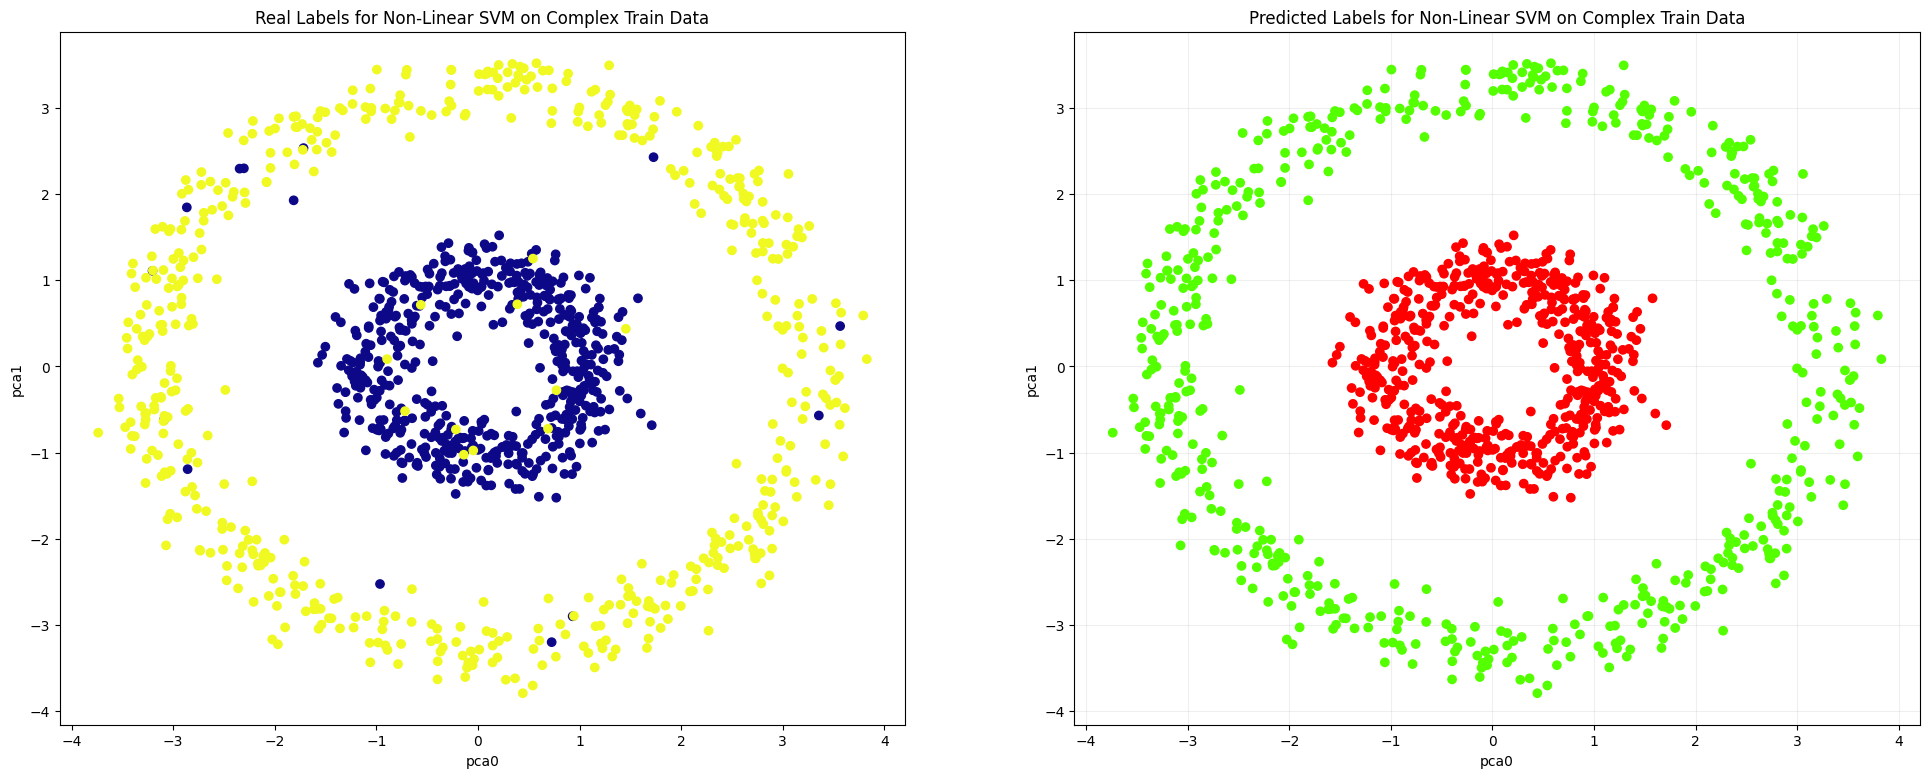

In [38]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(
    x=pca_X_train[:, 0], y=pca_X_train[:, 1], c=y_train, cmap="plasma", zorder=1
)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Non-Linear SVM on Complex Train Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=pca_X_train[:, 0],
    y=pca_X_train[:, 1],
    c=train_predictions,
    cmap="prism",
    zorder=1,
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Non-Linear SVM on Complex Train Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

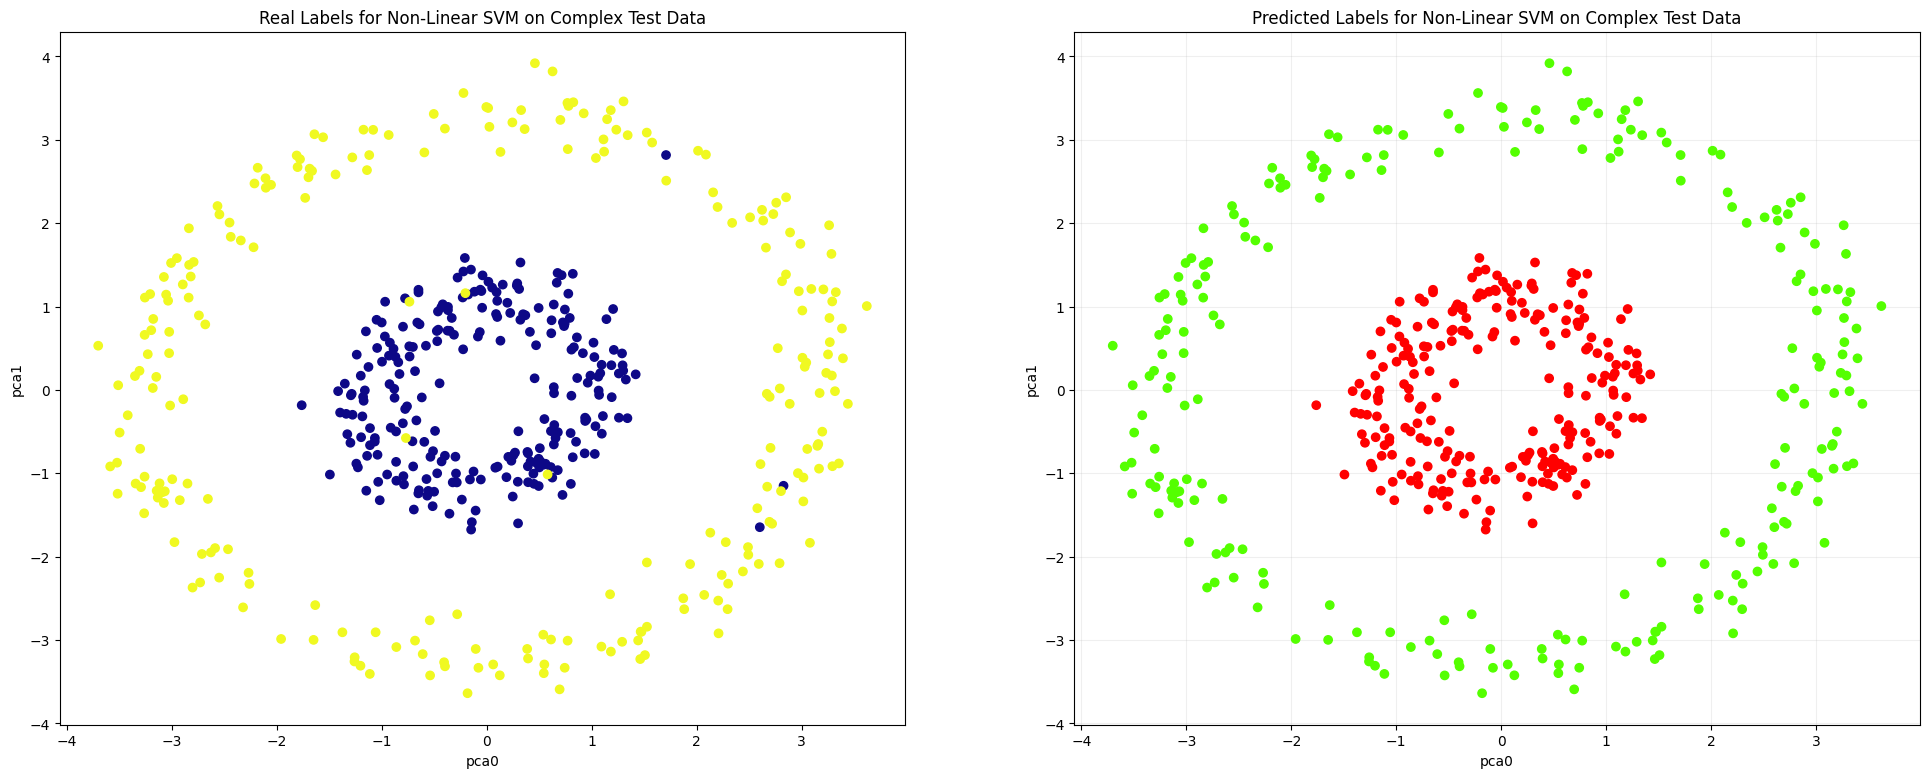

In [39]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(24, 9)

ax[0].scatter(x=pca_X_test[:, 0], y=pca_X_test[:, 1], c=y_test, cmap="plasma", zorder=1)
ax[0].set_axisbelow(True)
ax[0].set_title("Real Labels for Non-Linear SVM on Complex Test Data")
ax[0].set_xlabel("pca0")
ax[0].set_ylabel("pca1")

ax[1].scatter(
    x=pca_X_test[:, 0], y=pca_X_test[:, 1], c=test_predictions, cmap="prism", zorder=1
)
ax[1].set_axisbelow(True)
ax[1].set_title("Predicted Labels for Non-Linear SVM on Complex Test Data")
ax[1].set_xlabel("pca0")
ax[1].set_ylabel("pca1")

plt.grid(alpha=0.2)
plt.show()
plt.close()

##### (g) Desempenho

In [40]:
# Compute accuracy in train
train_predictions = nl_svm.predict(X_train)
train_accuracy = sum(train_predictions == y_train) / len(y_train)

print(f"Train Accuracy: {train_accuracy}")

# Computes the confusion matrix for train set
train_predictions = pd.Series(train_predictions)

true_minus = y_train == -1
true_plus = y_train == 1

true_negative = sum(train_predictions[true_minus] == -1)
false_negative = sum(train_predictions[true_plus] == -1)

true_positive = sum(train_predictions[true_plus] == 1)
false_positive = sum(train_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Train Accuracy: 0.9776586237712243


,True Negative,True Positive,Total
Predicted Negative,547,11,558
Predicted Positive,14,547,561
Total,561,558,1119


In [41]:
# Compute accuracy in test
test_predictions = nl_svm.predict(X_test)
test_accuracy = sum(test_predictions == y_test) / len(y_test)

print(f"Test Accuracy: {test_accuracy}")

# Computes the confusion matrix for test set
test_predictions = pd.Series(test_predictions)

true_minus = y_test == -1
true_plus = y_test == 1

true_negative = sum(test_predictions[true_minus] == -1)
false_negative = sum(test_predictions[true_plus] == -1)

true_positive = sum(test_predictions[true_plus] == 1)
false_positive = sum(test_predictions[true_minus] == 1)

confusion_matrix = {
    "Predicted Negative": [
        true_negative,
        false_negative,
        true_negative + false_negative,
    ],
    "Predicted Positive": [
        false_positive,
        true_positive,
        false_positive + true_positive,
    ],
    "Total": [
        true_negative + false_positive,
        false_negative + true_positive,
        true_negative + false_negative + false_positive + true_positive,
    ],
}
confusion_matrix = pd.DataFrame.from_dict(
    confusion_matrix,
    orient="index",
    columns=["True Negative", "True Positive", "Total"],
)
display(confusion_matrix)

Test Accuracy: 0.9854469854469855


,True Negative,True Positive,Total
Predicted Negative,238,4,242
Predicted Positive,3,236,239
Total,241,240,481


#### (h) Discussão

Uma maneira de superar as dificuldades impostas por dados não-linearmente separáveis no contexto do modelo SVM é com a utilização de kernels. Em essência, kernels são estruturas matemáticas que permitem representar e trabalhar com dados projetados em espaços de maior dimensão, potencialmente infinita, mas sem realizar essa projeção de maneira explícita. A ideia, portanto, é projetar os dados não-linearmente separáveis em um espaço de maior dimensão, no qual eles potencialmente serão linearmente separáveis por algum hiperplano, e aplicar o algoritmo do SVM nesse novo espaço para a obtenção de uma fronteira linear razoável de separação, a qual, caso mapeada de volta ao espaço original, seria não-linear. No caso, para os dados em mãos, foi utilizado um kernel gaussiano, o qual, em essência, projeta os pontos sobre uma distribuição gaussiana multidimensional. 

Para os dados simples, os quais apresentam uma fronteira de separação aproximadamente linear, não foi possível observar diferenças significativas entre ambas as abordagens. Os resultados foram melhores para a abordagem baseada em kernels, mas a abordagem linear, como já mencionado, também apresentou resultados satisfatórios.

Para os dados complexos, retomando a distribuição observável desses dados no espaço bi-dimensional - obtida via PCA -, é possível ver que, colocando uma gaussiana tri-dimensional sobre eles, os pontos da elipse interior, referentes à classe negativa, iriam ficar espacialmente acima dos pontos da elipse exterior, referentes à classe positiva, de modo que seja possível atravessar um hiperplano entre eles e os separar linearmente nesse espaço de maior dimensionalidade. Em outras palavras, pelo menos intuitivamente, observa-se como o processo parece ser coerente. De fato, a partir das visualizações apresentadas acima, é possível notar como as classes foram bem separadas visualmente, o que, inclusive, também é perceptível por meio das taxas de acurácia, as quais apresentaram valores muito bons, ainda mais quando comparados aos valores obtidos com a abordagem puramente linear.

Entrando em um pouco mais de detalhes sobre o kernel gaussiano, ele admite um hiperparâmetro gamma que controla o quão branda ou justa a projeção será. Um valor de gamma maior representa uma projeção mais justa que leva a normais multi dimensionais mais "apertadas" em cada ponto, com uma menor variância ao redor deles. O resultado disso é potencialmente um sobreajuste aos dados, o que também tem como consequência um aumento na quantidade de vetores de suporte e em uma fronteira de separação mais abrupta e menos suave. O valor escolhido para gamma foi de $1/8$ - isto é, 1/(n° de features de X) -, o que equivale à configuração "auto" da implementação da biblioteca SciKit Learn. Dados os resultados obtidos, julga-se que foi uma escolha adequada.

### **Esboço Explicativo**

*Feito à mão e anexado ao .pdf*

### **Discussão Crítica**

A principal limitação estrutural do SVM linear reside no fato de que ele consegue encontrar apenas fronteiras de separação lineares. Existe a possibilidade de se aplicar um relaxamento sobre as margens, o que torna o modelo robusto a ruídos nas proximidades da fronteira, mas, de qualquer forma, ele não consegue capturar fronteiras ótimas não-lineares em dados mais complexos. Essa limitação é resolvida com o uso de um kernel RBF, o qual projeta os dados em um espaço de maior dimensão no qual eles potencialmente são linearmente separáveis, de modo que o SVM tradicional seja aplicável. A fronteira de separação, uma vez retornada ao espaço original, pode apresentar não-linearidades.

Ambos os parâmetros C e γ possuem um impacto no balanço entre o viés e a variância do modelo. O parâmetro C controla o quanto a transgressão de pontos à margem é penalizada na função de perda, em que quanto maior o seu valor, maior é a penalização, o que resulta em uma margem mais ajustada aos dados e, portanto, a uma maior variância e a um menor viés. O parâmetro γ, por sua vez, controla o quanto a projeção gaussiana via kernal é ajustada a cada ponto. Quanto maior o seu valor, menor é a variância da normal ao redor do ponto, de modo que as margens de separação fiquem mais justas e a variância do modelo seja maior. De maneira análoga, quanto menores C e γ, mais larga será a margem, maior a generalização do modelo, maior seu viés e menor sua variância.

No processo de elaboração do problema dual para a otimização do SVM, tem-se que o vetor de pesos $w$, na verdade, é uma combinação linear dos vetores de suporte. Dessa forma, caso ele seja considerado o conjunto de parâmetros do modelo, sua esparsidade - a quantidade de coeficientes de $w$ iguais a 0 - é uma consequência direta das dimensões para as quais os vetores de suporte possuem valores próximos ou iguais a 0, além de que, de maneira geral, quanto menos vetores de suporte, mais esparsa é a solução, o que a torna menos complexa, mais leve, mais interpretável e mais generalizável. Além disso, seguindo a implementação feita neste trabalho, a inferência da classe de uma nova instância $x$ envolve uma soma linear na quantidade de vetores de suporte, de modo que seu impacto no custo de predição seja linear.